<a href="https://colab.research.google.com/github/Meaveryway/ML_Tests/blob/master/%5BPFE_Anti_Plagiat%5D_BERT_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 9.0MB/s 
     |████████████████████████████████| 2.9MB 44.8MB/s 
     |████████████████████████████████| 890kB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=efb26568577bfb43146d28970cbfd81656a642ed70b7a75bda0b7c426a317c54
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Dataframes en mode interactif
%load_ext google.colab.data_table
# %unload_ext google.colab.data_table

In [ ]:
# Formattage des nombres lors de l'affichage des numpy arrays.
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Accès à Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **BERT: Text similarity assessment**
DistilBERT est une version allégée et beaucoup plus rapide de BERT, avec une perte en performance assez minime

In [ ]:
# Pour DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Pour BERT standard
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# model & tokenizer pré-entrainé
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Testing data
BERT prend en entrée des phrases entières. Il s'agit donc juste de pairs de phrases (en anglais) prises du jeu d'essai du survey:
*   Phrases d'un document de plagiat verbatim & leurs équivalents paraphrasés.
Les pairs sont:
  *   [0, 4] 
  *   [1, 2] 
  *   [3, 5]
  *   [6, 7]





In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/PFE - Anti-Plagiat/strings.csv', delimiter=';', header=None)
data[0][8] = "While the modern concept of sustainable development is yet derived mostly from the 1987 Brundtland Report, it is also rooted in earlier ideas about sustainable forest management and twentieth-century environmental concerns. As the concept of sustainable development developed, it has shifted its focus more towards the economic development, social development and environmental protection for future generations. It has been suggested that the term 'sustainability' should be viewed as humanity's target goal of human-ecosystem equilibrium, while 'sustainable development' refers to the holistic approach and temporal processes that lead us to the endpoint of sustainability. Modern economies are endeavouring to reconcile ambitious economic development and obligations of preserving natural resources and ecosystems, as the two are usually seen as of conflicting nature. Instead of holding climate change commitments and other sustainability measures as a remedy to economic development, turning and leveraging them into market opportunities will do greater good. The economic development brought by such organized principles and practices in an economy is called Managed Sustainable Development (MSD). While the modern concept of sustainable development is yet derived mostly from the 1987 Brundtland Report, it is also rooted in earlier ideas about sustainable forest management and twentieth-century environmental concerns. As the concept of sustainable development developed, it has shifted its focus more towards the economic development, social development and environmental protection for future generations. It has been suggested that the term 'sustainability' should be viewed as humanity's target goal of human-ecosystem equilibrium, while 'sustainable development' refers to the holistic approach and temporal processes that lead us to the endpoint of sustainability. Modern economies are endeavouring to reconcile ambitious economic development and obligations of preserving natural resources and ecosystems, as the two are usually seen as of conflicting nature. Instead of holding climate change commitments and other sustainability measures as a remedy to economic development, turning and leveraging them into market opportunities will do greater good. The economic development brought by such organized principles and practices in an economy is called Managed Sustainable Development (MSD). "
data = data[:9]
plag_pairs = [(0, 4), (1, 2), (3, 5), (6, 7)]
data

,0,1
0,It’s all the more important because the futur...,NaN
1,An estimated 140 million people lost their job...,NaN
2,An evaluated 140 million individuals misplaced...,NaN
3,"As the lockdown was eased, many went back to w...",NaN
4,t’s all the more vital since the long run for ...,NaN
5,"As the lockdown was facilitated, numerous went...",NaN
6,while many others saw their salaries drastical...,NaN
7,whereas numerous others saw their pay rates de...,NaN
8,While the modern concept of sustainable develo...,NaN


## Preprocessing
Les étapes de pré-traitement suivantes sont propres aux modèles BERT:
1.   Tokenisation des phrases en mots et sous-mots (similaire à du stemming mais qui préserve tout) + ajouts des jetons CLS et SEP + remplacement de chaque jeton par son ID.
2.   Padding: afin d'avoir des vecteurs de même taille (= à la taille du plus long vecteur) afin d'avoir une matrice qui est beaucoup plus rapide à traiter qu'une liste de vecteurs.
3.   Génération du masque: complémente le padding pour différencier ce qui est du texte et ce qui est juste du padding. Il s'agit de vecteurs avec des 0 là où il s'agit d'un pad, 1 sinon.



### Tokenization

In [ ]:
tokenized_data = data[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_data

0    [101, 2009, 1521, 1055, 2035, 1996, 2062, 2590...
1    [101, 2019, 4358, 8574, 2454, 2111, 2439, 2037...
2    [101, 2019, 16330, 8574, 2454, 3633, 28616, 22...
3    [101, 2004, 1996, 5843, 7698, 2001, 10987, 101...
4    [101, 1056, 1521, 1055, 2035, 1996, 2062, 8995...
5    [101, 2004, 1996, 5843, 7698, 2001, 19601, 101...
6    [101, 2096, 2116, 2500, 2387, 2037, 20566, 210...
7    [101, 6168, 3365, 2500, 2387, 2037, 3477, 6165...
8    [101, 2096, 1996, 2715, 4145, 1997, 9084, 2458...
Name: 0, dtype: object

### Padding

In [ ]:
max_len = 0
for i in tokenized_data.values:
    if len(i) > max_len:
        max_len = len(i)

padded_data = np.array([i + [0]*(max_len-len(i)) for i in tokenized_data.values])

In [ ]:
print(np.array(padded_data).shape)
#padded_data

(9, 396)


### Masking

In [ ]:
attention_mask = np.where(padded_data != 0, 1, 0)
attention_mask.shape

(9, 396)

## Processing
On transforme les vecteurs de tokens en BERT embeddings en les injectant au modèle.

- On récupère les outputs des 768 niveaux cachès de BERT sur **hidden_states**

Pour notre cas, seuls les embeddings des phrases entières nous intéressent. Ceux-là sont mis dans les jetons [CLS] au début de chaque vecteur. On récupére donc juste la première colonne de chacune des 768 matrices.

In [ ]:
input_ids = torch.tensor(padded_data)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
hidden_states

BaseModelOutput([('last_hidden_state',
                  tensor([[[ 0.0660, -0.0181, -0.0963,  ..., -0.0901,  0.5605,  0.2927],
                           [-0.1691, -0.3056, -0.2971,  ...,  0.1781,  0.6015,  0.1504],
                           [ 0.1936, -0.1980,  0.9554,  ...,  0.0653,  0.1003, -0.1532],
                           ...,
                           [ 0.1892, -0.2617,  0.1574,  ...,  0.0660,  0.1374,  0.1561],
                           [ 0.2004, -0.1002,  0.1440,  ...,  0.0536,  0.0455, -0.0287],
                           [ 0.1837, -0.1760,  0.0588,  ...,  0.1419,  0.0128,  0.0611]],
                  
                          [[-0.1571, -0.2777, -0.2036,  ..., -0.2306,  0.2623,  0.0264],
                           [-0.0872, -0.0878, -0.4473,  ..., -0.0924,  0.7465, -0.0404],
                           [ 0.0802, -0.1467, -0.2955,  ..., -0.2977,  0.2818, -0.3092],
                           ...,
                           [ 0.3007, -0.1435,  0.1085,  ..., -0.0463,  0.026

In [ ]:
features = hidden_states[0][:,0,:].numpy()
features

array([[0.066, -0.018, -0.096, ..., -0.090, 0.561, 0.293],
       [-0.157, -0.278, -0.204, ..., -0.231, 0.262, 0.026],
       [-0.149, -0.243, -0.174, ..., -0.294, 0.495, 0.017],
       ...,
       [-0.059, -0.277, -0.240, ..., -0.144, 0.405, 0.164],
       [-0.001, -0.237, -0.161, ..., -0.171, 0.530, 0.158],
       [-0.325, 0.013, -0.256, ..., -0.305, 0.313, 0.362]], dtype=float32)

# Calcul de la similarité entre deux phrases:
Chaque vecteur de features correspond à la représentation BERT complète d'une phrase. On peut exploiter ces vecteurs d'une manière quasi-identique aux représentations vectorielles classiques comme Word2Vec.

#### **Exemple: similarité entre deux phrases (instance de plagiat) avec la distance cosine (la plus utilisée):**

Similarity = __0.90089226__ for sentences: 
-  It’s all the more important because the future for oil and gas companies is more uncertain than ever, which makes the future of their pipelines more uncertain, 
- An estimated 140 million people lost their jobs after India locked down its economy in March to stop the outbreak


In [ ]:
from numpy import dot
from numpy.linalg import norm

cos_sim = dot(features[1], features[2])/(norm(features[1])*norm(features[2]))
print("Similarity =", cos_sim, "for sentences: \n-", data[0][0], "\n -", data[0][1])

Similarity = 0.9008924 for sentences: 
-  It’s all the more important because the future for oil and gas companies is more uncertain than ever, which makes the future of their pipelines more uncertain, 
 - An estimated 140 million people lost their jobs after India locked down its economy in March to stop the outbreak


# Détéction des instances paires de plagiat dans un mini corpus (matching).
Indépendemment de la distance ou combinaison de distances utilisée, le concept reste le même:

- Calculer la distance/similarité entre chaque paires du corpus.
- Les instances de plagiats doivent donner la distance la plus petite, ou la similarité la plus grande.

BERT digére le contexte, il est donc en mesure de détécter le plagiat à un niveau sémantique.

*Distance = 1 - Similarité

- Sur les heatmaps, sont indiquées en bleu les instances de plagiat.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(features)
print(similarity_matrix)

[[1.000 0.789 0.887 0.914 0.971 0.906 0.883 0.891 0.890]
 [0.789 1.000 0.901 0.866 0.777 0.837 0.879 0.851 0.772]
 [0.887 0.901 1.000 0.923 0.901 0.924 0.948 0.944 0.842]
 [0.914 0.866 0.923 1.000 0.908 0.978 0.915 0.910 0.869]
 [0.971 0.777 0.901 0.908 1.000 0.908 0.883 0.895 0.864]
 [0.906 0.837 0.924 0.978 0.908 1.000 0.907 0.908 0.859]
 [0.883 0.879 0.948 0.915 0.883 0.907 1.000 0.987 0.842]
 [0.891 0.851 0.944 0.910 0.895 0.908 0.987 1.000 0.865]
 [0.890 0.772 0.842 0.869 0.864 0.859 0.842 0.865 1.000]]


0     It’s all the more important because the futur...
1    An estimated 140 million people lost their job...
2    An evaluated 140 million individuals misplaced...
3    As the lockdown was eased, many went back to w...
4    t’s all the more vital since the long run for ...
5    As the lockdown was facilitated, numerous went...
6    while many others saw their salaries drastical...
7    whereas numerous others saw their pay rates de...
8    While the modern concept of sustainable develo...
Name: 0, dtype: object


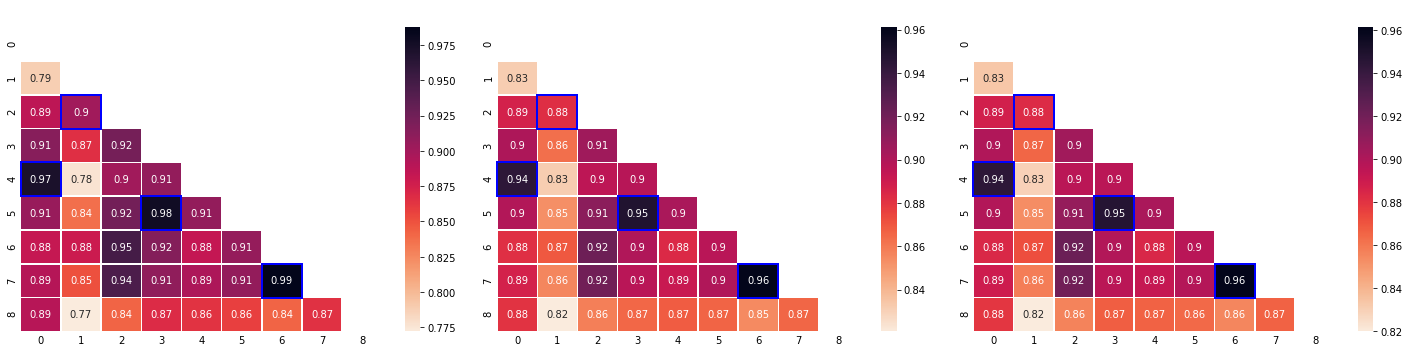

In [ ]:
print(data[0])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5))
cmap = sns.cm.rocket_r

mask = np.triu(similarity_matrix)
ax = sns.heatmap(similarity_matrix, ax=ax1, annot=True, mask=mask, cmap=cmap, linewidths=.5)
ax.set_title("Similarité Cosine", color="white").set_fontsize(20)

for pair in plag_pairs:
  ax.add_patch(Rectangle(pair,1,1, fill=False, edgecolor='blue', lw=2, clip_on=False))
ax.tick_params(length=0)

##------------------------------------
from sklearn.metrics.pairwise import manhattan_distances
distance_matrix_manhattan = manhattan_distances(features)
#similarity_matrix[similarity_matrix > 0.99999] = float("nan")

# normalisation:
norm = np.linalg.norm(distance_matrix_manhattan)
similarity_matrix_manhattan = 1- distance_matrix_manhattan/norm

mask_manhattan = np.triu(similarity_matrix_manhattan)
ax_manhattan = sns.heatmap(similarity_matrix_manhattan, ax = ax2, annot=True, mask=mask_manhattan, cmap=cmap, linewidths=.5)
ax_manhattan.set_title("Similarité Manhattan", color="white").set_fontsize(20)

for pair in plag_pairs:
  ax_manhattan.add_patch(Rectangle(pair,1,1, fill=False, edgecolor='blue', lw=2, clip_on=False))
ax_manhattan.tick_params(length=0)

##-----------------------------------
from sklearn.metrics import pairwise_distances
distance_matrix_euclidean = pairwise_distances(features, metric = "euclidean")
#similarity_matrix[similarity_matrix > 0.99999] = float("nan")

# normalisation:
norm = np.linalg.norm(distance_matrix_euclidean)
similarity_matrix_euclidean = 1- distance_matrix_euclidean/norm

mask_euclidean = np.triu(similarity_matrix_euclidean)
ax_euclidean = sns.heatmap(similarity_matrix_euclidean, ax=ax3, annot=True, mask=mask_euclidean, cmap=cmap, linewidths=.5)
ax_euclidean.set_title("Similarité Euclidienne", color="white").set_fontsize(20)

for pair in plag_pairs:
  ax_euclidean.add_patch(Rectangle(pair,1,1, fill=False, edgecolor='blue', lw=2, clip_on=False))

ax_euclidean.tick_params(length=0)
##-----------------------------------

plt.tight_layout()
plt.show()

# Corrélation entre les distances:
Les diatances utilisées, ainsi que d'autres ayant été testées, sont pratiquement correllées voire quasi similaires comme le cas de la distance Manhattan/Cityblock et Euclidienne.

Il peut donc faire objet d'optimisation le choix de la distance ou la combinaison de distances la plus représentative et la plus utile pour l'analuse de la similarité textuelle.

From the sklearn documentation: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’, ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]

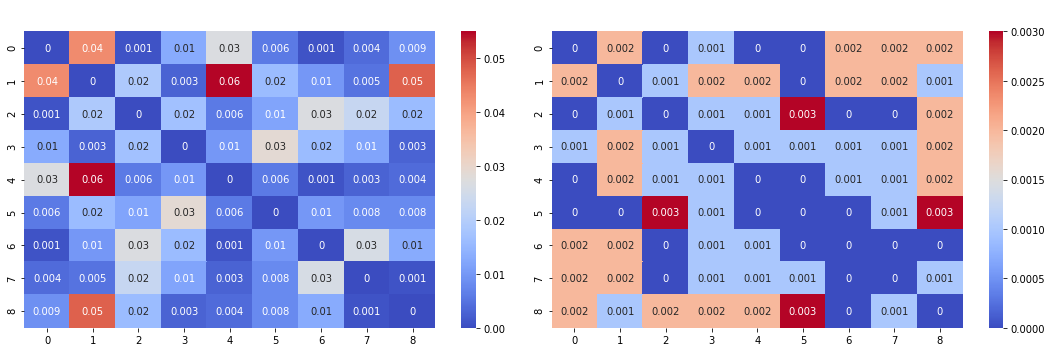

In [ ]:
cosine_manhattan_matrix = np.absolute(similarity_matrix - similarity_matrix_manhattan)
cosine_manhattan_matrix = cosine_manhattan_matrix.round(3)

manhattan_euclidean_matrix = np.absolute(similarity_matrix_euclidean - similarity_matrix_manhattan)
manhattan_euclidean_matrix = manhattan_euclidean_matrix.round(3)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

sns.heatmap(cosine_manhattan_matrix, ax=ax1, annot=True, cmap="coolwarm", fmt=".0g").set_title("Cosine Vs Manhattan", color="white").set_fontsize(25)
sns.heatmap(manhattan_euclidean_matrix, ax=ax2, annot=True, cmap="coolwarm", fmt=".0g").set_title("Manhattan Vs Euclidean", color="white").set_fontsize(25)

plt.tight_layout()
plt.show()
